<a href="https://colab.research.google.com/github/MichelNivard/3-causal-sem-models/blob/main/Adaptive_Lasso_instrumental_variable_structural_equation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Lasso instrumental variable structural equation model 

This `R` notebook is associated with the preprint "link" and [github repo](https://github.com/MichelNivard/3-causal-sem-models/tree/main) in which I (Michel Nivard), together with colleagues outline three feasible ways for causal inference in latent explanatory models in psychological science. The goal is to highlight how techniques from across diciplines can be used to identify (network) models, which have been key features of psychological theory at least since 2006, in the context of SEM.

There are two other notebooks outlining two alternate techniques. This notebook uses [`lessSEM`
](https://jhorzek.github.io/lessSEM/) and Adaptive Lasso penalties to identify an instrumental variable structural equation model if (many) of the instruments are invalid. We further install some other pacgages for convenience. This step might take a while to run, put on a pot of coffee or a kettle for tea, brows the socials or catch up on email and then come back to this browser window in 10-15 minutes.



In [ ]:
install.packages("lavaan")
install.packages("lessSEM")
install.packages("qgraph")
install.packages("semPlot")

library(lessSEM)
library(lavaan)
library(qgraph)
library(semPlot)




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘arm’, ‘mi’, ‘lme4’, ‘StanHeaders’, ‘rpf’, ‘sem’, ‘rockchalk’, ‘OpenMx’




## Data simulations
Having loaded the required packages we'll simulate some data. Data simualtion allows us to created faux data where te true model/process in known and some we can be certain about our ability to retrieve it using the model of preference (or not). Here we simulate a network (the same one we use in the paper), that gives rise to 5 correlated variables, the correlations etween these avriables are relatively homogeneous (between 0.52 and 0.65) and if these where psychometric tests people could very reasonably impose or assume a latent variable model where one unobserved factor causes the correlated responses on the five variables. 



In [ ]:

## Network data simulations
set.seed(123)
n <- 20000 # Sample size

b <- matrix(c(   0,  .22,   0,  .24,  .35,  # The network weights (bidirectional regression paths between endogeneous variables y1 to y5)
                 0,   0,   .15,  .31,  .0,
                 .35,  .2,   0, -.14,   .3,
                 .14, -.2,  .36,   0,   .4,
                 0, .30, .15,   -.15,    0), 5,5,byrow=T)


x <- matrix(rnorm(n*15),n,15) # 15 potential Instrumental variables


y1 <- runif(1,.1,.2)*x[,1] + runif(1,.1,.2)*x[,2] + runif(1,.1,.2)*x[,3] + rnorm(n)  # endogeneous variables y1 to y5  
y2 <- runif(1,.1,.2)*x[,4] + runif(1,.1,.2)*x[,5] + runif(1,.1,.2)*x[,6] + rnorm(n)  # are a function of instruments x1 to x15
y3 <- runif(1,.1,.2)*x[,7] + runif(1,.1,.2)*x[,8] + runif(1,.1,.2)*x[,9] +  rnorm(n) 
y4 <- runif(1,.1,.2)*x[,10] + runif(1,.1,.2)*x[,11] + runif(1,.1,.2)*x[,12] +  rnorm(n)
y5 <- runif(1,.1,.2)*x[,13] + runif(1,.1,.2)*x[,14] + runif(1,.1,.2)*x[,15] +  rnorm(n) 

ye <- cbind(y1,y2,y3,y4,y5) # endogeneous variables 

y <- t(solve(diag(ncol(b)) - b) %*% t(ye)) # the "network" defined in b governs the relations between the endogeneous variables 

colnames(x) <- c("x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15")
colnames(y) <- c("y1","y2","y3","y4","y5")
data <- cbind(y,x)
                 

So what does the simulated data look like?


In [ ]:
cor(y) # correlation between endogneous variables

,y1,y2,y3,y4,y5
y1,1.0000000,0.5581019,0.6318291,0.6466738,0.5510298
y2,0.5581019,1.0000000,0.6254194,0.5143259,0.5395162
y3,0.6318291,0.6254194,1.0000000,0.5880671,0.5911580
y4,0.6466738,0.5143259,0.5880671,1.0000000,0.5342347
y5,0.5510298,0.5395162,0.5911580,0.5342347,1.0000000


Which was the result of the following network:

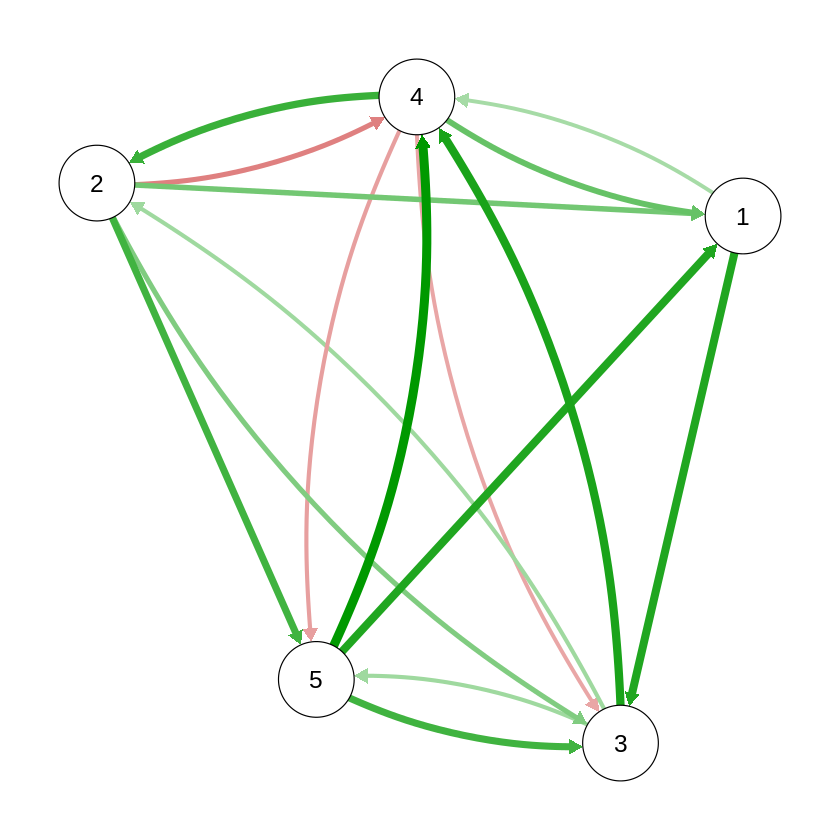

In [ ]:
# plot b as a network, note the transpose because qgraph is different then lavaan.
qgraph(t(b))

## Fitting an Adaptive Lasso instrumental variable model

We new take this data and use `lessSEM` to fit an instrumental variable model where we don't predefien which instruments (variables x) load on which endogeneous variables (variables y) but instead regress all y on all x, but shrink thoses effects with a Lasso penalty. we will also regress each y on all other y (a network).

First we define the model in the lavaan SEM syntax (if you aren't familiar see [here](https://lavaan.ugent.be/tutorial/syntax1.html) for details).

briefly like in other R formula's `~` represents a regression relation, at this stage out model only consists of regression relations. 



In [ ]:

lavaanSyntax <- "
      y1 ~ b12*y2 + b13*y3 + b14*y4 + b15*y5 + a11*x1  + a12*x2 + a13*x3 + a14*x4 + a15*x5 + a16*x6 + a17*x7 + a18*x8  + a19*x9 + a110*x10 + a111*x11 + a112*x12 + a113*x13 + a114*x14 + a115*x15
      y2 ~ b21*y1 + b23*y3 + b24*y4 + b25*y5 + a21*x1  + a22*x2 + a23*x3 + a24*x4 + a25*x5 + a26*x6 + a27*x7 + a28*x8  + a29*x9 + a210*x10 + a211*x11 + a212*x12 + a213*x13 + a214*x14 + a215*x15
      y3 ~ b31*y1 + b32*y2 + b34*y4 + b35*y5 + a31*x1  + a32*x2 + a33*x3 + a34*x4 + a35*x5 + a36*x6 + a37*x7 + a38*x8  + a39*x9 + a310*x10 + a311*x11 + a312*x12 + a313*x13 + a314*x14 + a315*x15
      y4 ~ b41*y1 + b42*y2 + b43*y3 + b45*y5 + a41*x1  + a42*x2 + a43*x3 + a44*x4 + a45*x5 + a46*x6 + a47*x7 + a48*x8  + a49*x9 + a410*x10 + a411*x11 + a412*x12 + a413*x13 + a414*x14 + a415*x15
      y5 ~ b51*y1 + b52*y2 + b53*y3 + b54*y4 + a51*x1  + a52*x2 + a53*x3 + a54*x4 + a55*x5 + a56*x6 + a57*x7 + a58*x8  + a59*x9 + a510*x10 + a511*x11 + a512*x12 + a513*x13 + a514*x14 + a515*x15
      "
lavaanModel <- lavaan::sem(lavaanSyntax,
                           data = data,
                           meanstructure = TRUE)


Warning message in lav_model_vcov(lavmodel = lavmodel, lavsamplestats = lavsamplestats, :
“lavaan WARNING:
    Could not compute standard errors! The information matrix could
    not be inverted. This may be a symptom that the model is not
    identified.”


You'll get a warning that the `lavaan` model isn't identified, which is actually expected. Its expected because we regress all y on all other y, we are trying to estimate `y1 ~ y5` while also trying to estimate `y5 ~ y1`! 

However, if we shrink a significant number of the y ~ x relations to 0 (i.e. let the Adaptive Lasso find instrumental vairables for us) then the paths `y1 ~ y5` and `y5 ~ y1` eventually become identified concurrently.

In [ ]:
lsem <- adaptiveLasso(
  # pass the fitted lavaan model
  lavaanModel = lavaanModel,
  # names of the regularized parameters:
  regularized = c( "a11", "a12", "a13", "a14", "a15","a16", "a17","a18","a19","a110","a111","a112","a113","a114","a115",
                   "a21", "a22", "a23", "a24", "a25","a26", "a27","a28","a29","a210","a211","a212","a213","a214","a215",
                   "a31", "a32", "a33", "a34", "a35","a36", "a37","a38","a39","a310","a311","a312","a313","a314","a315",
                   "a41", "a42", "a43", "a44", "a45","a46", "a47","a48","a49","a410","a411","a412","a413","a414","a415",
                   "a51", "a52", "a53", "a54", "a55","a56", "a57","a58","a59","a510","a511","a512","a513","a514","a515"
  ), #"b12","b13","b14","b15","b21","b23","b24","b25","b31","b32","b34","b35","b41","b42","b43","b45","b51","b52","b53","b54"), #
  # in case of lasso and adaptive lasso, we can specify the number of lambda
  # values to use. lessSEM will automatically find lambda_max and fit
  # models for nLambda values between 0 and lambda_max. For the other
  # penalty functions, lambdas must be specified explicitly
  lambdas = seq(1/n,100/n,1/n) )


Warning message in .extractSEMFromLavaan(lavaanModel = lavaanModel, whichPars = whichPars, :
“lavaanModel has option fixed.x set to TRUE. This is currently not fully supported by lessSEM. Be sure to check the results.”
Note
• Could not extract initial Hessian from lavaan. Switching to initialHessian = 'compute'.


  |======================================================================| 100%

The model then gives us the following coeficients:

In [ ]:
coef(lsem, criterion = "BIC")

                                                                              
  Tuning         ||--||  Estimates                                            
 ------- ------- ||--|| ---------- ---------- ---------- ---------- ----------
  lambda   alpha ||--||        b12        b13        b14        b15        a11
 ======= ======= ||--|| ========== ========== ========== ========== ==========
  0.0012  1.0000 ||--||     0.1959     0.0141     0.2550     0.3658     0.1309
                                                                             
                                                                             
 ---------- ---------- ---------- ---------- ---------- ---------- ----------
        a12        a13        a14        a15        a16        a17        a18
 ========== ========== ========== ========== ========== ========== ==========
     0.1835     0.1662          .          .          .          .          .
                                                          

And a network that looks like this:



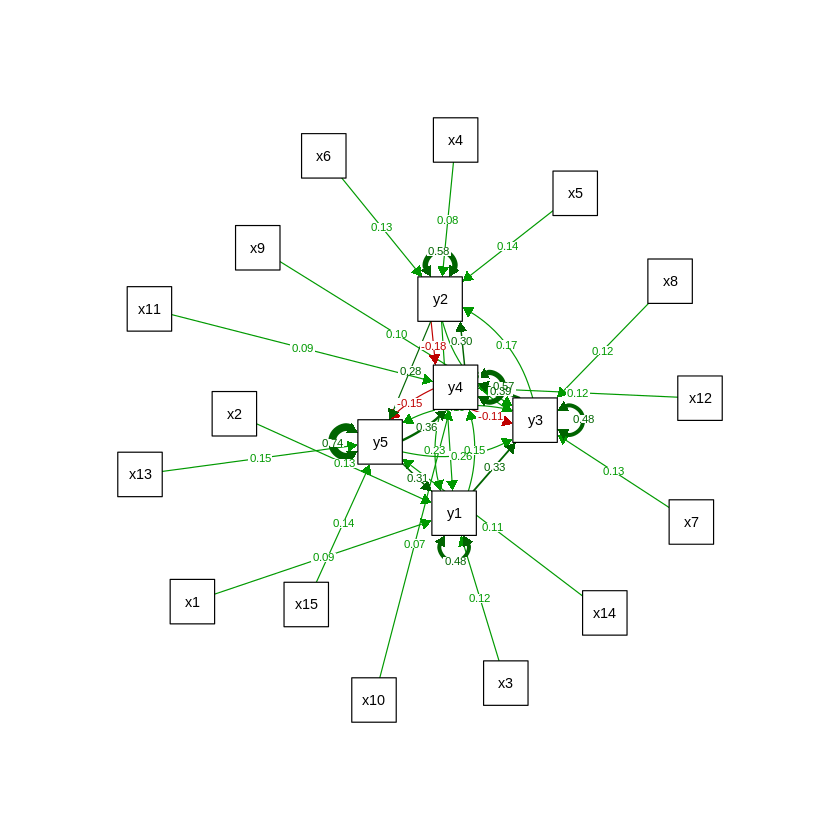

In [ ]:
lavaanModel <- lessSEM2Lavaan(regularizedSEM = lsem, 
                              criterion = "BIC")


semPaths(lavaanModel,
         what = "std",
         curve=T,
         fade=F,
         exoCov = F,
         exoVar = F,
         residuals = T,
         minimum = 0.05,
         layout=c("spring"),
         intercept=F)

Finally lets compare the estimates with the simulated parameters:

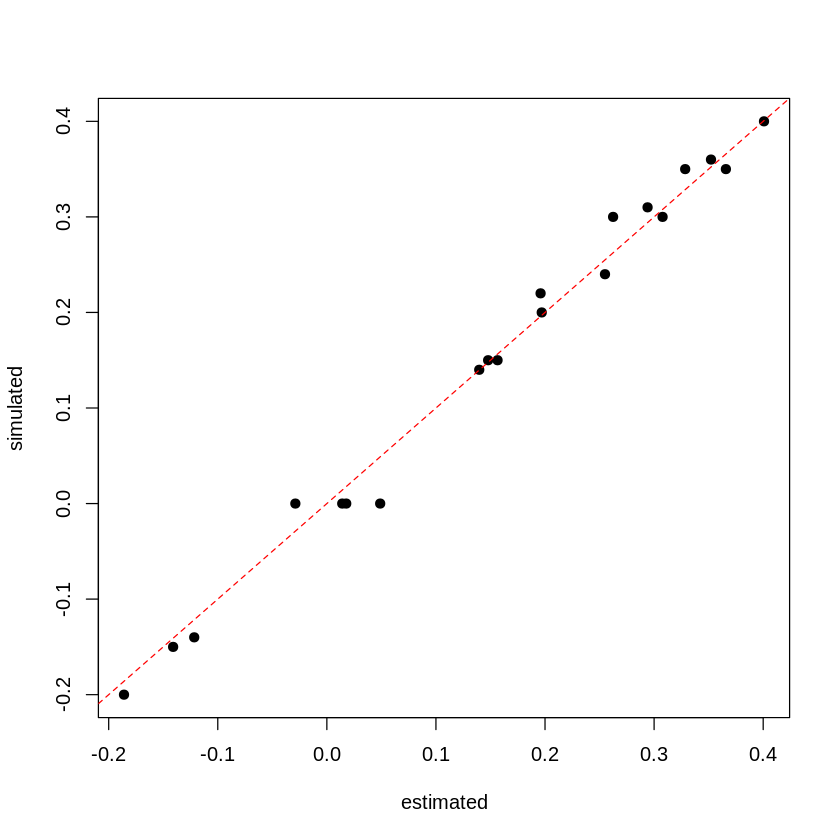

In [ ]:
output <- coef(lsem, criterion = "BIC")@estimates
estimated <- as.vector(select(as.data.frame(output),contains('b')))
c <- b # get true network
diag(c) <- NA # omit diag
simulated <- na.omit(as.vector(t(c))) # vectorize

plot(estimated,simulated,pch=19) # plot treu vs estimated paths
abline(0,1,col="red",lty="dashed")

## Adaptive Lasso in the presence of confounding.


We can add confounders, 2 in this case, `u1` and `u2` to illustate how with a minor ajustment the model still holds up well (as expected obviously!).



In [ ]:
# a network model

u1 <- .5*rnorm(n)
u2 <- .5*rnorm(n)


y[,1] <- y[,1] + u1
y[,2] <- y[,2] + u1
y[,3] <- y[,3] + u2 + u1
y[,4] <- y[,4] + u2
y[,5] <- y[,5] 


data <- cbind(y,x)

We (re)simuated some data, and we need to specify a slightly adjusted model:

In [ ]:
lavaanSyntax <- "
      y1 ~~  s11*y1 + s12*y2 + s13*y3 + s14*y4 + s15*y5
      y2 ~~  s22*y2 + s23*y3 + s24*y4 + s25*y5
      y3 ~~  s33*y3 + s34*y4 + s35*y5
      y4 ~~  s44*y4 + s45*y5
      y5 ~~  s55*y5
      y1 ~ b12*y2 + b13*y3 + b14*y4 + b15*y5 + a11*x1  + a12*x2 + a13*x3 + a14*x4 + a15*x5 + a16*x6 + a17*x7 + a18*8  + a19*x9 + a110*x10 + a111*x11 + a112*x12 + a113*x13 + a114*x14 + a115*x15
      y2 ~ b21*y1 + b23*y3 + b24*y4 + b25*y5 + a21*x1  + a22*x2 + a23*x3 + a24*x4 + a25*x5 + a26*x6 + a27*x7 + a28*8  + a29*x9 + a210*x10 + a211*x11 + a212*x12 + a213*x13 + a214*x14 + a215*x15
      y3 ~ b31*y1 + b32*y2 + b34*y4 + b35*y5 + a31*x1  + a32*x2 + a33*x3 + a34*x4 + a35*x5 + a36*x6 + a37*x7 + a38*8  + a39*x9 + a310*x10 + a311*x11 + a312*x12 + a313*x13 + a314*x14 + a315*x15
      y4 ~ b41*y1 + b42*y2 + b43*y3 + b45*y5 + a41*x1  + a42*x2 + a43*x3 + a44*x4 + a45*x5 + a46*x6 + a47*x7 + a48*8  + a49*x9 + a410*x10 + a411*x11 + a412*x12 + a413*x13 + a414*x14 + a415*x15
      y5 ~ b51*y1 + b52*y2 + b53*y3 + b54*y4 + a51*x1  + a52*x2 + a53*x3 + a54*x4 + a55*x5 + a56*x6 + a57*x7 + a58*8  + a59*x9 + a510*x10 + a511*x11 + a512*x12 + a513*x13 + a514*x14 + a515*x15
      "
lavaanModel <- lavaan::sem(lavaanSyntax,
                           data = data,
                           meanstructure = TRUE)


Warning message in lav_model_vcov(lavmodel = lavmodel, lavsamplestats = lavsamplestats, :
“lavaan WARNING:
    Could not compute standard errors! The information matrix could
    not be inverted. This may be a symptom that the model is not
    identified.”


We then run the new model

In [ ]:

                           
lsem2 <- adaptiveLasso(
  # pass the fitted lavaan model
  lavaanModel = lavaanModel,
  # names of the regularized parameters:
  regularized = c( "a11", "a12", "a13", "a14", "a15","a16", "a17","a18","a19","a110","a111","a112","a113","a114","a115",
                   "a21", "a22", "a23", "a24", "a25","a26", "a27","a28","a29","a210","a211","a212","a213","a214","a215",
                   "a31", "a32", "a33", "a34", "a35","a36", "a37","a38","a39","a310","a311","a312","a313","a314","a315",
                   "a41", "a42", "a43", "a44", "a45","a46", "a47","a48","a49","a410","a411","a412","a413","a414","a415",
                   "a51", "a52", "a53", "a54", "a55","a56", "a57","a58","a59","a510","a511","a512","a513","a514","a515"
  ), #"b12","b13","b14","b15","b21","b23","b24","b25","b31","b32","b34","b35","b41","b42","b43","b45","b51","b52","b53","b54"), #
  # in case of lasso and adaptive lasso, we can specify the number of lambda
  # values to use. lessSEM will automatically find lambda_max and fit
  # models for nLambda values between 0 and lambda_max. For the other
  # penalty functions, lambdas must be specified explicitly
  lambdas = seq(1/n,100/n,1/n) )


Warning message in .extractSEMFromLavaan(lavaanModel = lavaanModel, whichPars = whichPars, :
“lavaanModel has option fixed.x set to TRUE. This is currently not fully supported by lessSEM. Be sure to check the results.”
Note
• Could not extract initial Hessian from lavaan. Switching to initialHessian = 'compute'.


  |======================================================================| 100%

Lets see whether the method held up in terms of how well it recovered the model parameters. 

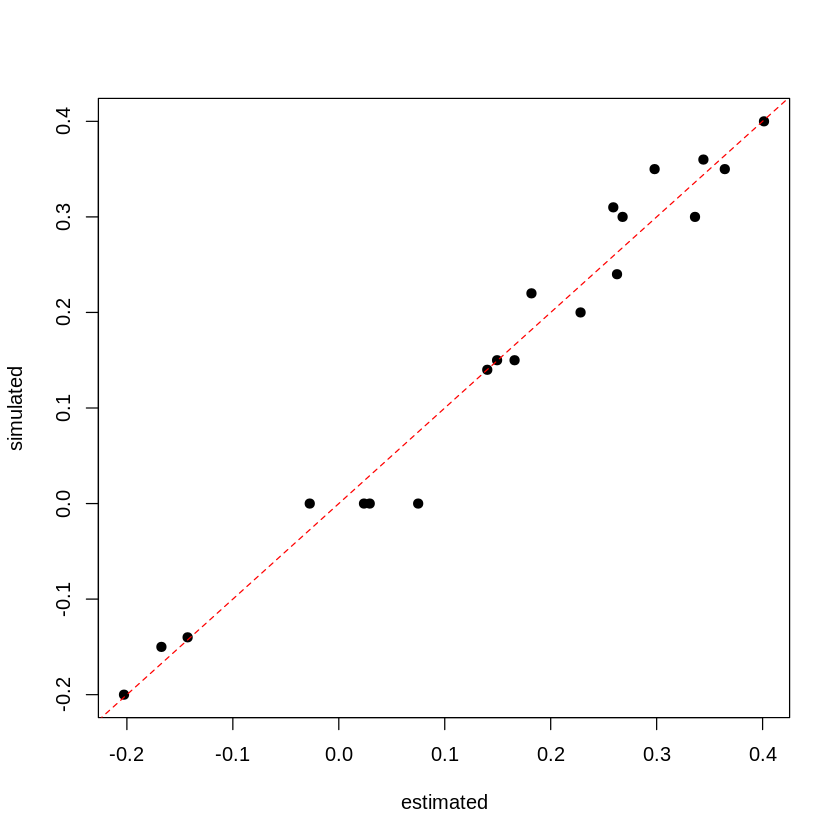

In [ ]:
output <- coef(lsem2, criterion = "BIC")@estimates
estimated <- as.vector(select(as.data.frame(output),contains('b')))
c <- b # get true network
diag(c) <- NA # omit diag
simulated <- na.omit(as.vector(t(c))) # vectorize

plot(estimated,simulated,pch=19) # plot treu vs estimated paths
abline(0,1,col="red",lty="dashed")